<a href="https://colab.research.google.com/github/Gabriel-git24/Cacao_disease_classification/blob/main/simple_ds2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner --quiet
import time
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_size = (224,224)
batch_size = 32

split_dir = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/binary_classification/Cacao_Splits"
checkpoint_path = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/binary_classification/checkpoint/best_model(simple).keras"

#we are implementing data augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

train_generator = train_datagen.flow_from_directory(
    directory=f"{split_dir}/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = val_datagen.flow_from_directory(
    directory=f"{split_dir}/val",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_generator = val_datagen.flow_from_directory(
    directory=f"{split_dir}/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

Found 218 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [ ]:
from ast import mod
#building model using feature extraction
  #Feature extraction is using a pre-existing model's layers, freezing them but then removing the final layer or output layer and adding your own.

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False, #removing the classification layer
    input_shape=image_size + (3,)
)
base_model.trainable = False #freezing the layers to avoid data from retraining the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) #0.5

outputs = Dense(1,
                activation="sigmoid",
                kernel_regularizer=l2(0.0001) #0.0005
                )(x)

final_model = Model(
    inputs=base_model.input,
    outputs=outputs
)

final_model.compile(
    optimizer=Adam(learning_rate=.0005),
    loss="binary_crossentropy",
    metrics = ["accuracy"]
)

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
start_time = time.time()

history = final_model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = [early_stopping, model_checkpoint]
)

end_time = time.time()
elapsed_time_seconds = end_time - start_time
elapsed_time_hours = elapsed_time_seconds / 3600
print(f"Total training time: {elapsed_time_hours:.2f} hours")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.5738 - loss: 0.8519 - val_accuracy: 0.6739 - val_loss: 0.6275
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.6283 - loss: 0.7606 - val_accuracy: 0.6739 - val_loss: 0.6139
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.6524 - loss: 0.6791 - val_accuracy: 0.6957 - val_loss: 0.5922
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.6765 - loss: 0.6590 - val_accuracy: 0.6957 - val_loss: 0.5781
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.6770 - loss: 0.6150 - val_accuracy: 0.6957 - val_loss: 0.5698
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.6954 - loss: 0.6312 - val_accuracy: 0.6957 - val_loss: 0.5552
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.6816 - loss: 0.6758 - val_accuracy: 0.7174 - val_loss: 0.5480
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.6766 - loss: 0.6005 - val_accuracy: 0.6739 - val_loss: 0.5567
Epoch 9/

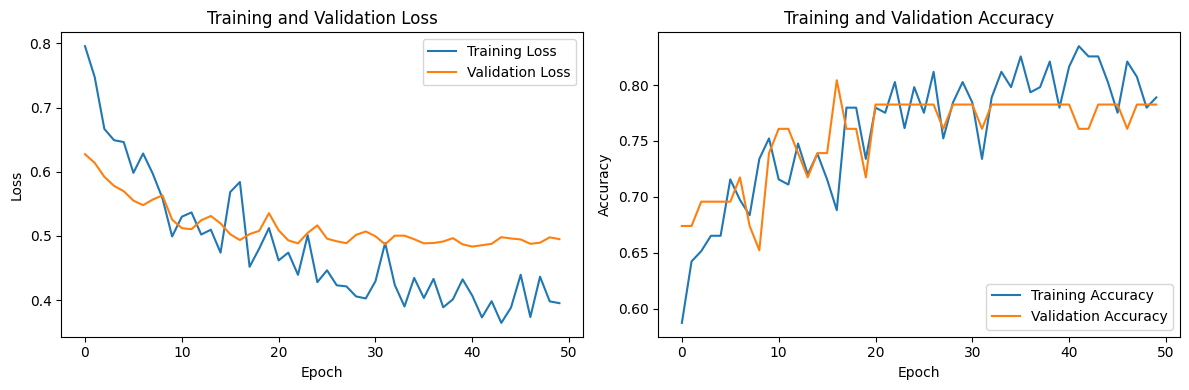

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_model.load_weights(checkpoint_path)

test_loss, test_accuracy = final_model.evaluate(test_generator)
print(f"Final test loss: {test_loss:.4f}")
print(f"Final test accuracry: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.7118 - loss: 0.5538
Final test loss: 0.5591
Final test accuracry: 0.7083
